# Задача Б: поиск фейковых отзывов

Отзывы на Wildberries — вид обратной связи, которую можно оставить только после заказа товара. Отзывы отображаются в карточке товара (см. рис.) и отражаются в виде рейтинга товара в звездах с текстовым комментарием.

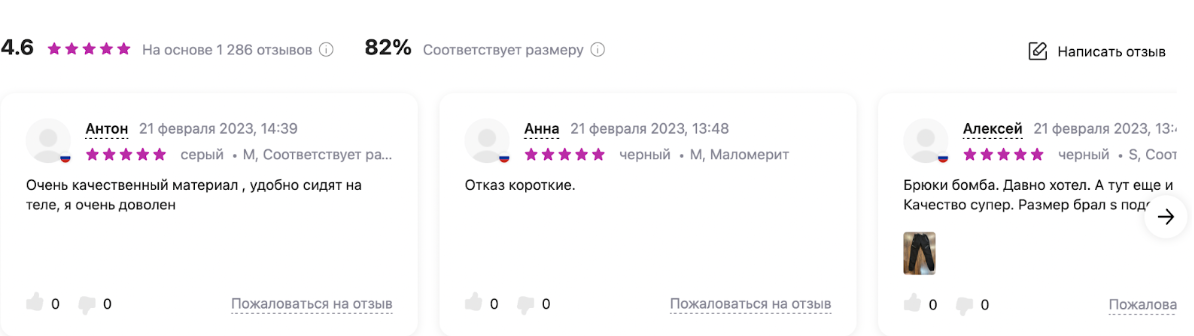
#### Задача
Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара. 
Существует два вида таких отзывов: 
положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.
#### Данные
Предоставляем список размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)
#### Результат
Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.


## <u>Этап 1.</u> Проработка и формализация задачи, определение таргета

Задача состоит в том, чтобы определить является отзыв фейковым или нет. Это задача бинарной классификации, в качестве объектов принимаются отзывы, каждый из которых представлен множеством количественных признаков `f1`, `f2`,  ... `f8`. <b>Таргетом</b> в данной задаче является индикатор Y = {1 - если фейк, 0 - иначе}.

Таким образом, <b>результатом решения</b> должна стать модель, которая по входным данным: `f1`, `f2`, ... `f8` определяет является отзыв фейковым или нет.

## <u>Этап 2.</u> Первичный анализ данных, очищение данных

Импортируем все необходимые модули, считаем данные и посмотрим на первые пять строк.

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
data = pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip')

In [139]:
data.head(5)

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


Уберем ненужные для нас столбцы `id1`, `id2`, `id3`, `text` и запишем эту таблицу в новую переменную <b><i>df</i></b>.

In [140]:
df = data.iloc[:, 4:]
df.head(5)

,f1,f2,f3,f4,f5,f6,f7,f8,label
0,1,1,1.0,11,13,4.272727,18,36,0
1,10,6,2.7,46,4,4.434783,90,109,1
2,4,4,4.0,14,0,4.500000,4,6,0
3,6,6,5.0,374,30,4.772727,14,15,1
4,19,18,5.0,6,4,5.000000,26,33,0


Посмотрим на сводную статистику по данным и на типы каждого из столбцов.

In [142]:
display(df.describe())
df.info()

,f1,f2,f3,f4,f5,f6,f7,f8,label
count,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,19.409862,16.216459,4.232658,808.603586,216.628562,4.453445,48.155620,94.356708,0.264169
std,35.746560,26.070112,1.179999,2509.350075,802.154201,0.619495,67.107753,329.525613,0.440960
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.000000,2.000000,4.076923,26.000000,6.000000,4.331071,8.000000,13.000000,0.000000
50%,8.000000,7.000000,4.764706,116.000000,26.000000,4.617978,30.000000,45.000000,0.000000
75%,23.000000,20.000000,5.000000,493.000000,110.000000,4.809556,65.000000,107.000000,1.000000
max,638.000000,550.000000,5.000000,35375.000000,15683.000000,5.000000,1058.000000,9243.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      3123 non-null   int64  
 1   f2      3123 non-null   int64  
 2   f3      3123 non-null   float64
 3   f4      3123 non-null   int64  
 4   f5      3123 non-null   int64  
 5   f6      3123 non-null   float64
 6   f7      3123 non-null   int64  
 7   f8      3123 non-null   int64  
 8   label   3123 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 219.7 KB


Как видим, все данные приведены в подходящий формат.

<b>Проверим есть ли пропуски в данных.</b>

In [143]:
df.isnull().sum()

f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

Пропусков нет

Посмотрим на соотношение фейковых и непроплаченных отзывов.

In [141]:
fakes_count = df[df['label'] == 1].shape[0]
print('Количество фейковых отзывов: ', fakes_count)
print('Количество реальных отзывов: ', df.shape[0] - fakes_count)

Количество фейковых отзывов:  825
Количество реальных отзывов:  2298


Посмотрим на матрицу корреляции через тепловую карту. 

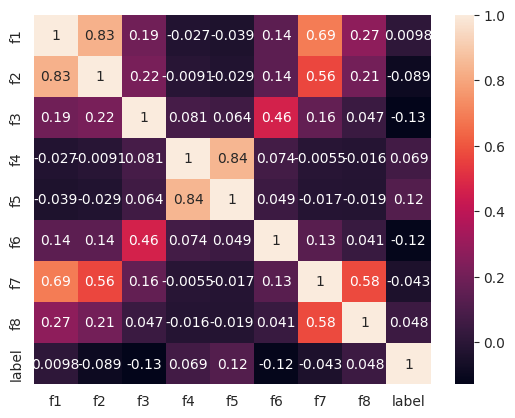

In [161]:
corr = df.corr()
sns.heatmap(corr, annot=True);

Можно заметить 
 * Высокую положительную корреляцию между признаками: `f1` и `f2`, `f4` и `f5`;
 * Среднюю положительную корреляцию между признаками: `f1` и `f7`, `f2` и `f7`, `f7` и `f8`;

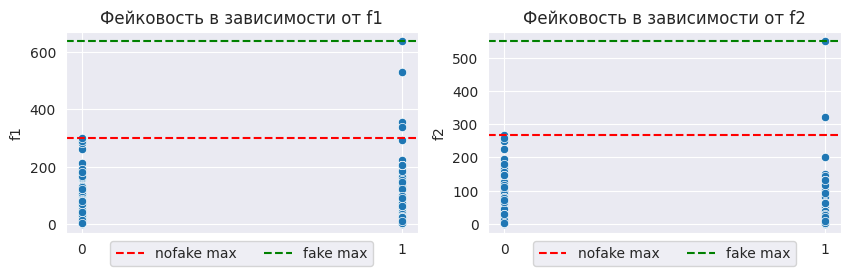

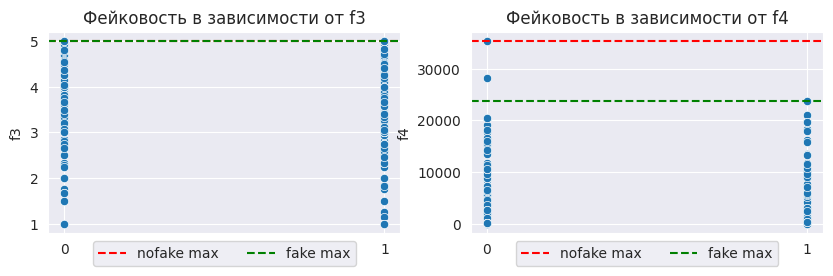

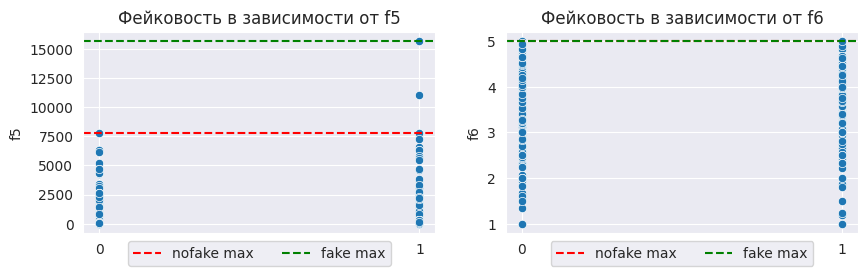

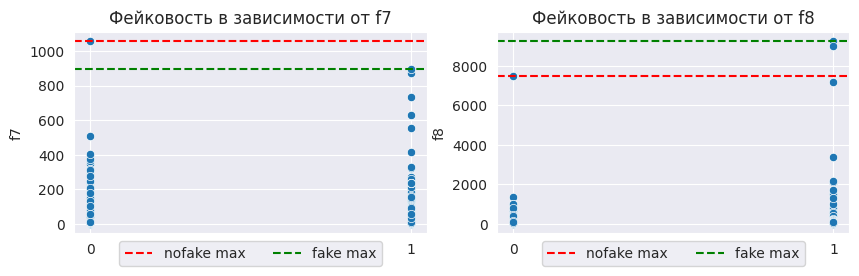

In [144]:
for i in range(1, 9, 2):
    plt.figure(figsize=(10, 12))
    
    plt.subplot(4, 2, i)
    plt.title(f'Фейковость в зависимости от f{i}')
    sns.scatterplot(y=df[f'f{i}'], x=df['label'])
    plt.axhline(y=df[df['label'] == 0][f'f{i}'].max(), color='red', linestyle='--', label='nofake max')
    plt.axhline(y=df[df['label'] == 1][f'f{i}'].max(), color='green', linestyle='--', label='fake max')
    plt.xticks([0, 1])
    plt.xlabel(None)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    
    plt.subplot(4, 2, i+1)
    plt.title(f'Фейковость в зависимости от f{i+1}')
    sns.scatterplot(y=df[f'f{i+1}'], x=df['label'])
    plt.axhline(y=df[df['label'] == 0][f'f{i+1}'].max(), color='red', linestyle='--', label='nofake max')
    plt.axhline(y=df[df['label'] == 1][f'f{i+1}'].max(), color='green', linestyle='--', label='fake max')
    plt.xticks([0, 1])
    plt.xlabel(None)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    
    plt.show()

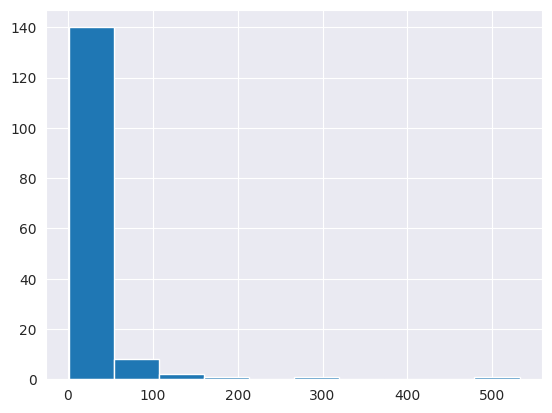

In [233]:
df['f1'].value_counts().hist();

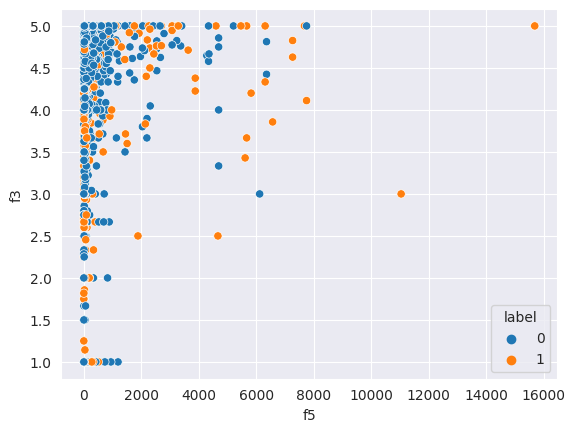

In [247]:
sns.scatterplot(x='f5', y='f3', hue='label', data=df)
plt.show()

<b>Посмотрим есть ли выбросы среди признаков f1..f8.</b> 

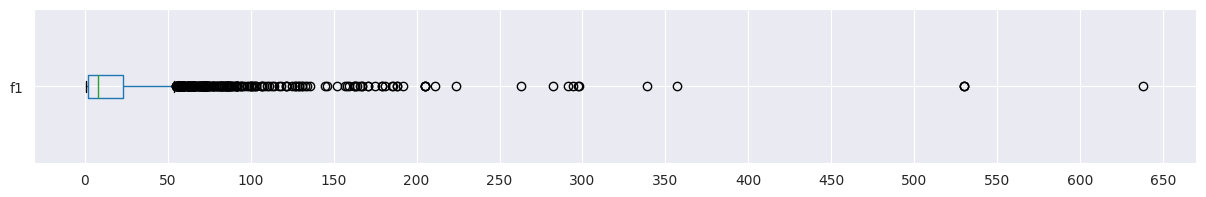

In [145]:
df.boxplot('f1', vert=False, figsize=(15, 2))
plt.xticks(np.arange(0, 700, 50))
plt.show();

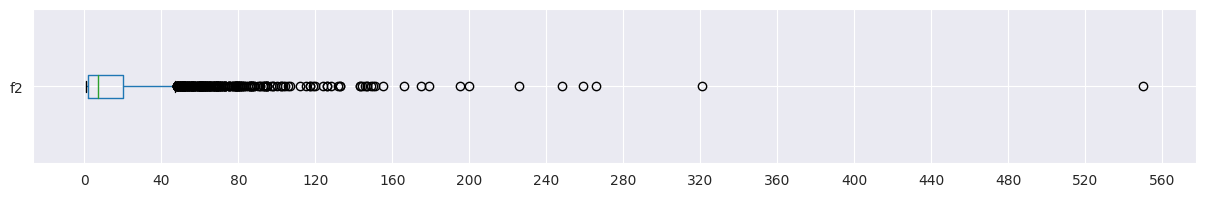

In [146]:
df.boxplot('f2', vert=False, figsize=(15, 2))
plt.xticks(np.arange(0, 600, 40))
plt.show();

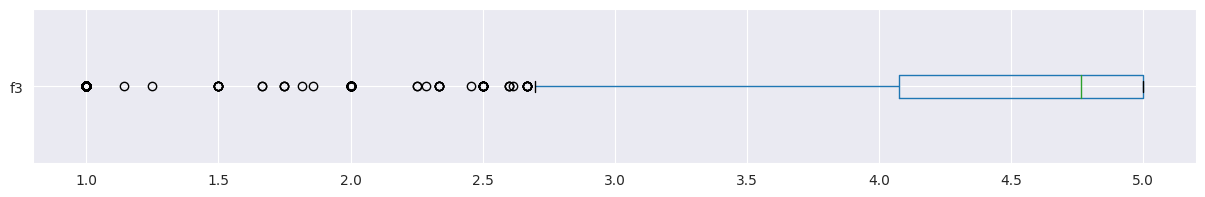

In [147]:
df.boxplot('f3', vert=False, figsize=(15, 2))
plt.show();

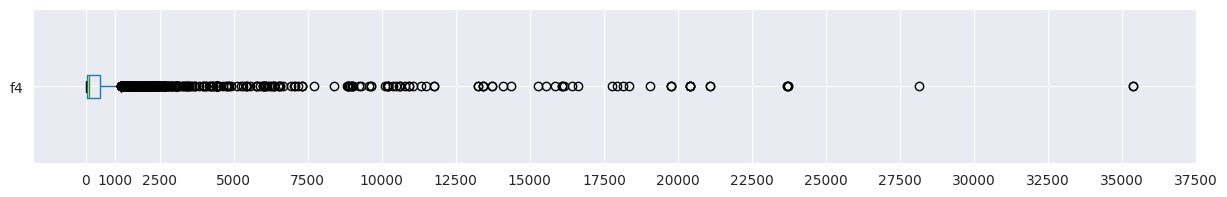

In [148]:
df.boxplot('f4', vert=False, figsize=(15, 2))
plt.xticks(np.append(np.arange(0, 40000, 2500), 1000))
plt.show();

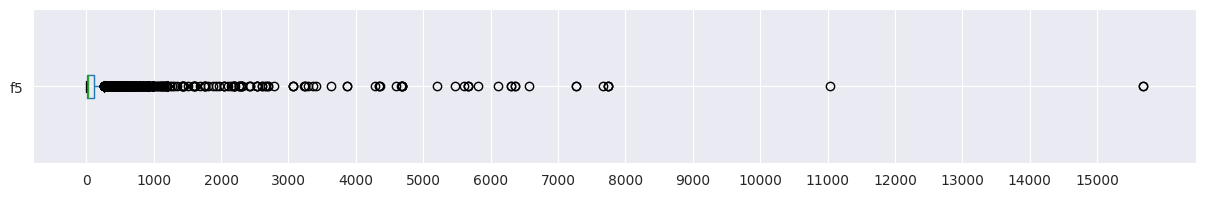

In [149]:
df.boxplot('f5', vert=False, figsize=(15, 2))
plt.xticks(np.arange(0, 16000, 1000))
plt.show();

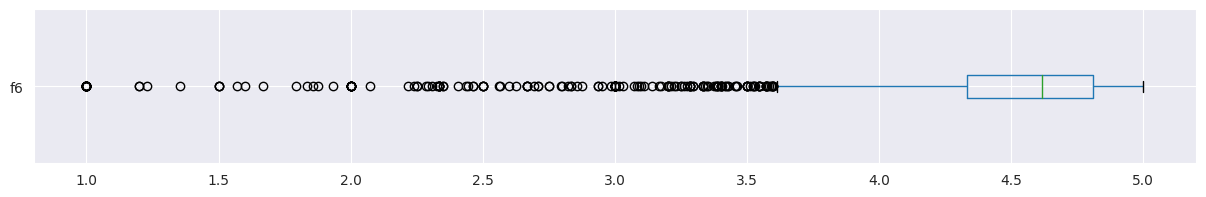

In [150]:
df.boxplot('f6', vert=False, figsize=(15, 2))
plt.show();

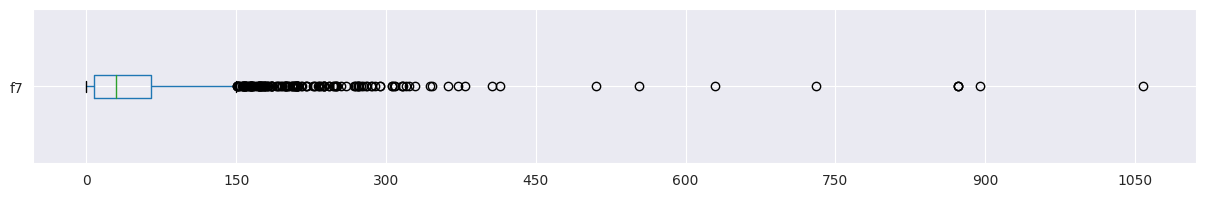

In [151]:
df.boxplot('f7', vert=False, figsize=(15, 2))
plt.xticks(np.arange(0, 1200, 150))
plt.show();

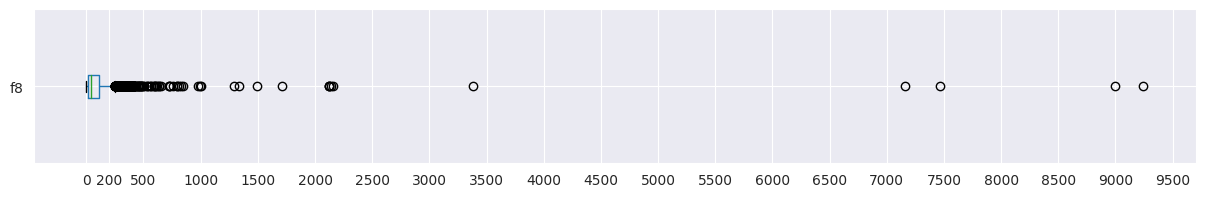

In [152]:
df.boxplot('f8', vert=False, figsize=(15, 2))
plt.xticks(np.append(np.arange(0, 10000, 500), 200))
plt.show();

In [280]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [249]:
X = df[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [279]:
# for i in range(1, 100):
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(i, model.score(X_test, y_test))

99 0.736235595390525


In [288]:
for i in range(1, 100):
    model = SVC(C=2 * i)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(i, model.score(X_test, y_test))

1 0.7195902688860435
2 0.7195902688860435
3 0.7208706786171575
4 0.7208706786171575
5 0.7208706786171575
6 0.7195902688860435
7 0.7195902688860435
8 0.7195902688860435
9 0.7195902688860435
10 0.7195902688860435
11 0.7195902688860435
12 0.7195902688860435
13 0.7183098591549296
14 0.7183098591549296
15 0.7183098591549296
16 0.7221510883482715
17 0.7247119078104993
18 0.7259923175416133
19 0.7259923175416133
20 0.7259923175416133
21 0.7247119078104993
22 0.7247119078104993
23 0.7247119078104993
24 0.7259923175416133
25 0.7259923175416133
26 0.7259923175416133
27 0.7272727272727273
28 0.7259923175416133
29 0.7272727272727273
30 0.7272727272727273
31 0.7272727272727273
32 0.7298335467349552
33 0.7311139564660691
34 0.7311139564660691
35 0.7311139564660691
36 0.7311139564660691
37 0.7311139564660691
38 0.7336747759282971
39 0.7336747759282971
40 0.7336747759282971
41 0.7336747759282971
42 0.7336747759282971
43 0.7336747759282971
44 0.7336747759282971
45 0.7336747759282971
46 0.73367477592829

In [131]:
model = LogisticRegression(n_jobs=10)
model.fit(X_train, y_train)
pred = model.predict(X_test)
model.score(X_test, y_test)

0.7516005121638925